In [28]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [120]:
import matplotlib.pyplot as plt

class Island:
    def __init__(self, xcentr=5, ycentr=5, radius=1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5 - self.radius

    def draw_island(self, color='blue'):
        return plt.Circle((self.xcentr, self.ycentr), self.radius, color=color)

    def getCoords(self):
        return [self.xcentr, self.ycentr]


In [121]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [122]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [123]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.prev_d = self.direction
        self.positions = [[self.x, self.y]]
        self.cum_d = 0
        
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)
        self.cum_d += abs(self.direction - self.prev_d)
        self.prev_d = self.direction
        
    def getCoords(self):
        return [self.x, self.y]
    
    def add_position(self):
        self.positions.append([self.x, self.y])
        
    def get_positions(self):
        return self.positions

In [177]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['left', 'right', 'idle']
        self.n_actions = len(self.action_space)
        self.n_features = 2

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}
        
        self.prev_dist = 0
        self.prev_i_dist = 0

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0
        
    def get_state(self):
        a = self.ship.getCoords()
        b = self.island.getCoords()
        c = self.flag.getCoords()
        dxi, dyi = b[0] - a[0], b[1] - a[1]
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        i_angle = math.atan2(dyi, dxi)
        return [f_angle - self.ship.direction, f_angle, dxf, dyf, i_angle - self.ship.direction, i_angle, dxi, dyi]

    def build_environment(self):
        rate = random.uniform(0.3, 0.5)
        dist = random.uniform(7, 15)
        angle = random.uniform(0, 2 * math.pi)
        self.flag = Island(0, 0, 1)
        self.ship = Ship(dist * math.cos(angle), dist * math.sin(angle))
        self.island = Island(rate * dist * math.cos(angle), rate * dist * math.sin(angle))
        a = self.ship.getCoords()
        c = self.flag.getCoords()
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        self.ship.direction = f_angle
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.island.get_dist(self.ship.x, self.ship.y)
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.get_state()
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()

        if action == 0:
            self.ship.direction += math.pi / 6
        elif action == 1:
            self.ship.direction -= math.pi / 6
        # elif action == 2:
        #     self.ship.v += 0.25
        # elif action == 3:
        #     self.ship.v -= 0.25
        
        self.ship.move(dt)
        
        self.ship.add_position()

        next_state = self.get_state()

        self.i += 1
        
        if self.flag.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = 20000
            done = True
            
            self.d = {}
            self.i = 0

        elif self.island.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = -10000
            done = True

            self.d = {}
            self.i = 0
            
        elif len(self.ship.get_positions()) > 500:
            done = True
            self.d = {}
            self.i = 0
            # print("Time limit exceeded")
            reward = -1000 * (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 2

        else:
            reward = (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 3
            reward -= 0.1 * (self.prev_i_dist - self.island.get_dist(self.ship.x, self.ship.y)) ** 3
            if reward < 0:
                reward *= 10
            # reward += 10 * (1 - self.ship.cum_d ** 2) * math.exp( - 0.5 * self.ship.cum_d ** 2) - 5
            done = False
        
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.island.get_dist(self.ship.x, self.ship.y)

        return next_state, reward, done 
    
    def draw_map(self):
        field, ax = plt.subplots()
        ax.set(xlim=(x_upper_bound * -2, x_upper_bound * 2), ylim=(y_upper_bound * -2, y_upper_bound * 2))
        ax.set_aspect(1)
        ax.add_artist(self.island.draw_island('green'))
        ax.add_artist(self.flag.draw_island())
        pos = self.ship.get_positions()
        for i in range(len(pos) - 1):
            ax.plot([pos[i][0], pos[i + 1][0]], [pos[i][1], pos[i + 1][1]], marker = 'o', color='r')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

Ключевая идея: подаем на вектор относительных координат острова и флага, а также пеленги на них.

In [178]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 8
EPISODES = 20000

In [185]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [186]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|                                                     | 0/20000 [00:00<?, ?it/s]

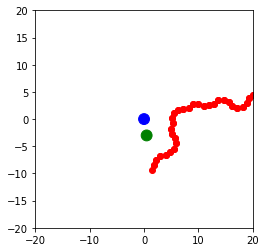

  0%|▏                                        | 100/20000 [00:25<1:58:00,  2.81it/s]

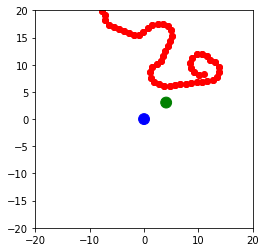

  1%|▍                                        | 200/20000 [00:59<1:33:21,  3.53it/s]

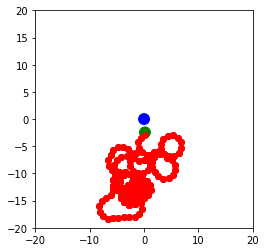

  1%|▌                                        | 298/20000 [01:26<1:02:55,  5.22it/s]

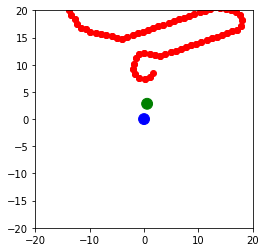

  2%|▊                                        | 400/20000 [01:54<2:00:35,  2.71it/s]

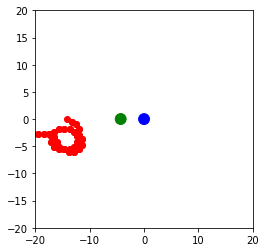

  2%|█                                        | 500/20000 [02:30<2:13:35,  2.43it/s]

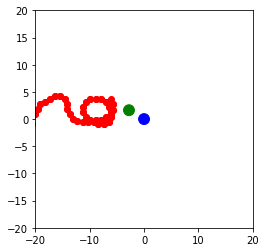

  3%|█▏                                       | 600/20000 [02:59<2:11:25,  2.46it/s]

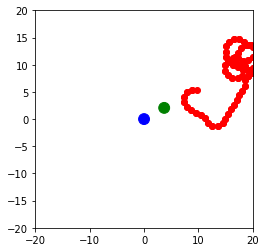

  4%|█▍                                       | 700/20000 [03:32<1:51:43,  2.88it/s]

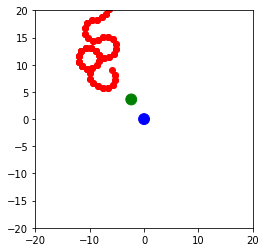

  4%|█▋                                       | 800/20000 [04:05<1:20:22,  3.98it/s]

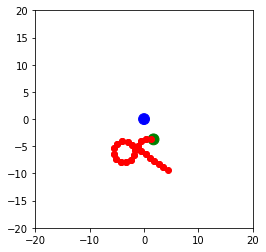

  4%|█▊                                       | 899/20000 [04:37<1:51:42,  2.85it/s]

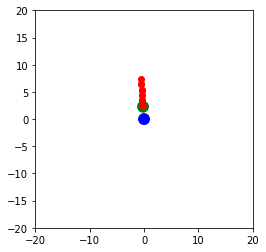

  5%|██                                      | 1000/20000 [05:02<1:14:39,  4.24it/s]

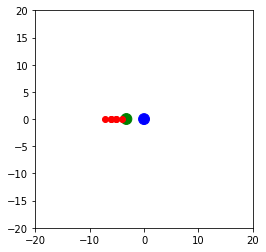

  6%|██▏                                     | 1100/20000 [05:28<1:22:54,  3.80it/s]

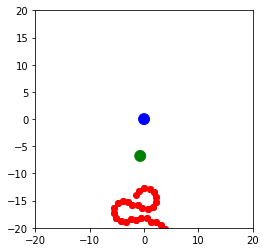

  6%|██▍                                     | 1198/20000 [06:03<1:55:10,  2.72it/s]

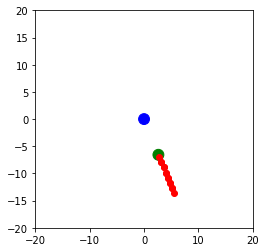

  6%|██▌                                     | 1299/20000 [06:33<1:51:12,  2.80it/s]

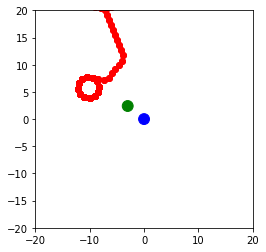

  7%|██▊                                     | 1400/20000 [07:00<1:09:47,  4.44it/s]

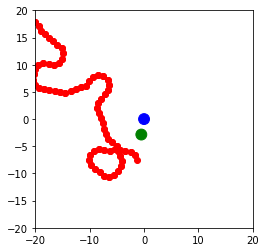

  7%|██▉                                     | 1498/20000 [07:23<1:36:02,  3.21it/s]

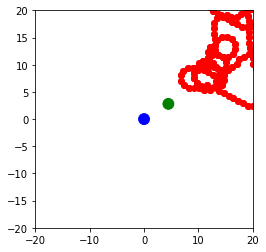

  8%|███▏                                    | 1600/20000 [07:57<1:13:32,  4.17it/s]

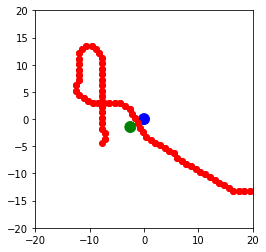

  8%|███▍                                    | 1700/20000 [08:27<1:12:51,  4.19it/s]

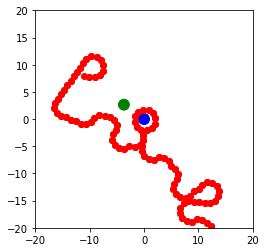

  9%|███▊                                      | 1800/20000 [08:53<51:14,  5.92it/s]

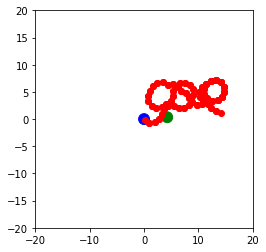

 10%|███▊                                    | 1900/20000 [09:18<1:23:41,  3.60it/s]

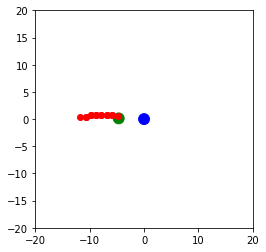

 10%|████▏                                     | 2000/20000 [09:41<57:31,  5.21it/s]

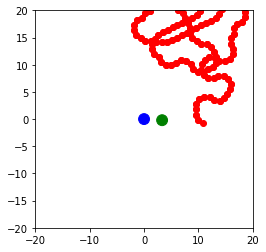

 10%|████▏                                   | 2100/20000 [10:06<1:29:14,  3.34it/s]

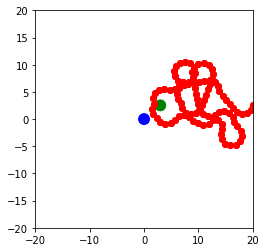

 11%|████▍                                   | 2200/20000 [10:36<1:45:39,  2.81it/s]

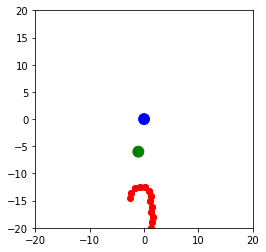

 11%|████▌                                   | 2299/20000 [11:06<1:46:25,  2.77it/s]

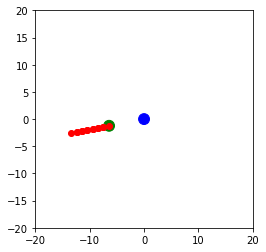

 12%|█████                                     | 2398/20000 [11:38<58:33,  5.01it/s]

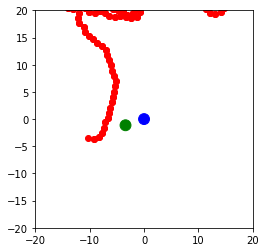

 12%|█████▎                                    | 2500/20000 [11:57<54:33,  5.35it/s]

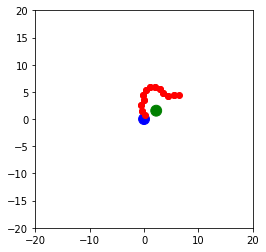

 13%|█████▍                                    | 2600/20000 [12:21<59:10,  4.90it/s]

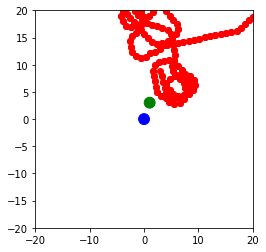

 14%|█████▍                                  | 2700/20000 [12:48<1:35:11,  3.03it/s]

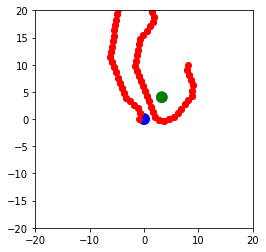

 14%|█████▌                                  | 2800/20000 [13:19<1:45:33,  2.72it/s]

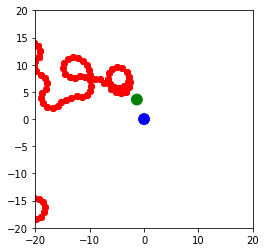

 14%|█████▊                                  | 2900/20000 [13:49<1:10:24,  4.05it/s]

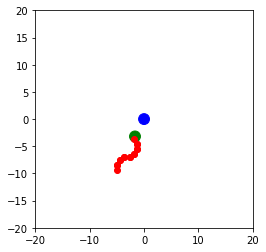

 15%|█████▉                                  | 2999/20000 [14:09<1:06:01,  4.29it/s]

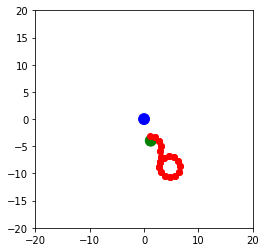

 16%|██████▏                                 | 3100/20000 [14:24<1:20:15,  3.51it/s]

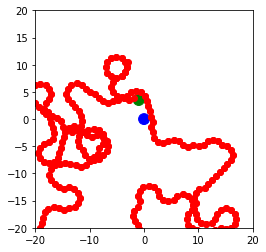

 16%|██████▍                                 | 3200/20000 [14:59<1:33:42,  2.99it/s]

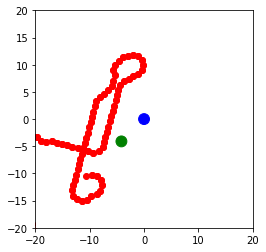

 16%|██████▉                                   | 3300/20000 [15:18<33:27,  8.32it/s]

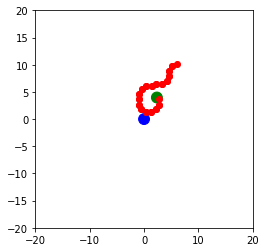

 17%|██████▊                                 | 3397/20000 [15:40<1:32:58,  2.98it/s]

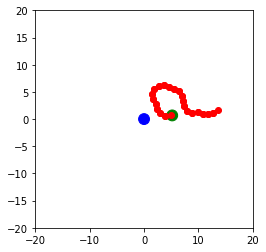

 18%|███████                                 | 3500/20000 [16:08<1:01:10,  4.50it/s]

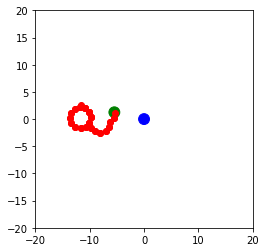

 18%|███████▏                                | 3600/20000 [16:42<1:40:02,  2.73it/s]

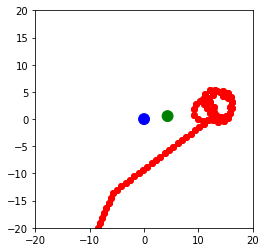

 18%|███████▍                                | 3700/20000 [17:20<1:57:53,  2.30it/s]

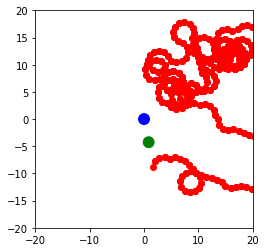

 19%|███████▌                                | 3800/20000 [17:53<1:54:08,  2.37it/s]

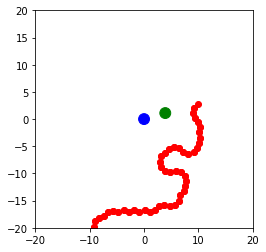

 19%|███████▊                                | 3897/20000 [18:22<1:01:50,  4.34it/s]

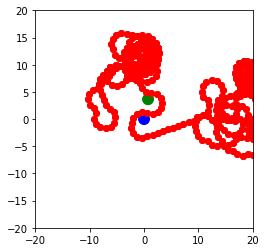

 20%|███████▉                                | 3999/20000 [18:51<1:17:36,  3.44it/s]

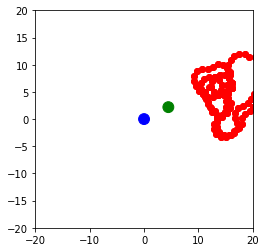

 20%|████████▏                               | 4099/20000 [19:20<1:14:33,  3.55it/s]

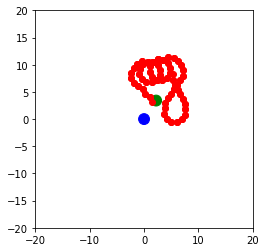

 21%|████████▊                                 | 4199/20000 [19:47<57:42,  4.56it/s]

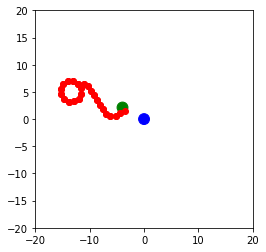

 21%|████████▌                               | 4299/20000 [20:17<1:43:13,  2.54it/s]

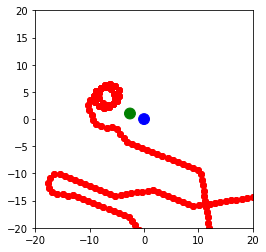

 22%|█████████▏                                | 4400/20000 [20:44<39:46,  6.54it/s]

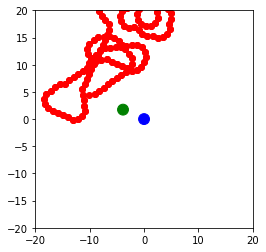

 22%|█████████                               | 4500/20000 [21:16<1:51:19,  2.32it/s]

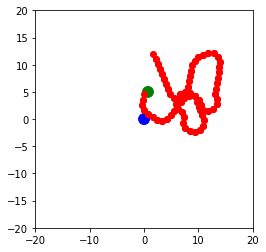

 23%|█████████▏                              | 4600/20000 [21:48<1:45:51,  2.42it/s]

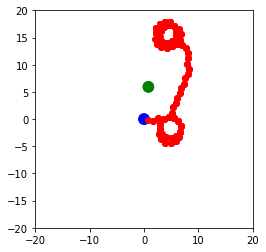

 24%|█████████▊                                | 4700/20000 [22:24<49:08,  5.19it/s]

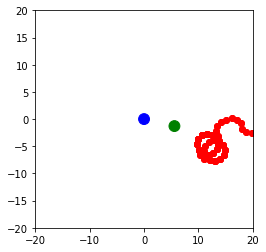

 24%|█████████▌                              | 4800/20000 [22:50<1:14:17,  3.41it/s]

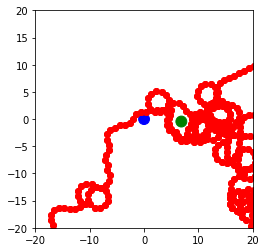

 24%|██████████▎                               | 4899/20000 [23:07<29:39,  8.48it/s]

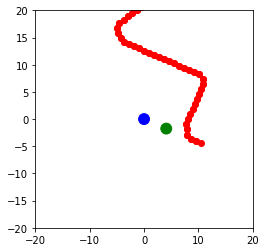

 25%|██████████▌                               | 5000/20000 [23:28<46:21,  5.39it/s]

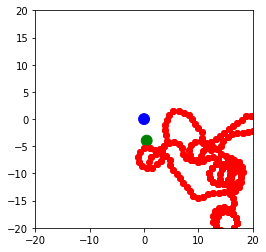

 26%|██████████▋                               | 5100/20000 [23:50<56:45,  4.38it/s]

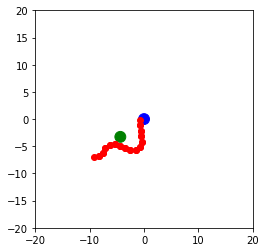

 26%|██████████▉                               | 5198/20000 [24:10<52:01,  4.74it/s]

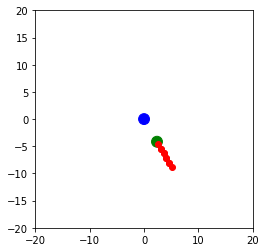

 26%|███████████▏                              | 5300/20000 [24:33<59:47,  4.10it/s]

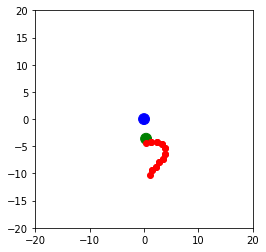

 27%|███████████▎                              | 5396/20000 [24:59<30:33,  7.96it/s]

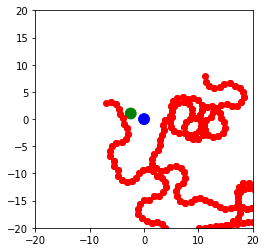

 28%|███████████▌                              | 5500/20000 [25:23<51:01,  4.74it/s]

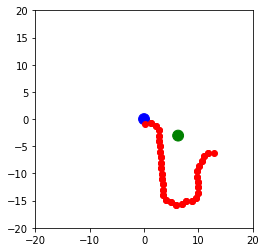

 28%|███████████▏                            | 5600/20000 [25:47<1:03:15,  3.79it/s]

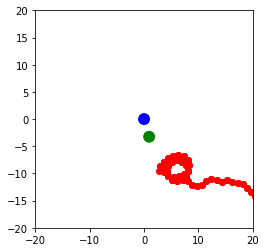

 28%|███████████▍                            | 5700/20000 [26:17<1:23:06,  2.87it/s]

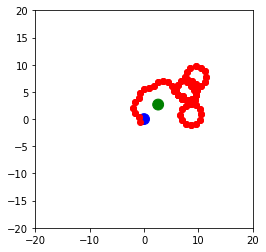

 29%|███████████▌                            | 5799/20000 [26:47<1:18:21,  3.02it/s]

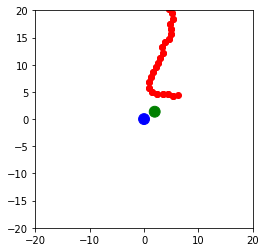

 30%|███████████▊                            | 5900/20000 [27:15<1:35:14,  2.47it/s]

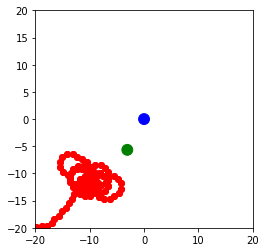

 30%|████████████                            | 6000/20000 [27:45<1:28:09,  2.65it/s]

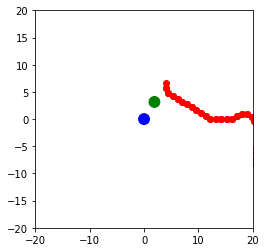

 30%|████████████▊                             | 6100/20000 [28:10<46:00,  5.04it/s]

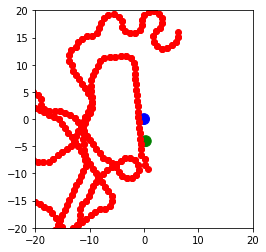

 31%|█████████████                             | 6200/20000 [28:41<58:37,  3.92it/s]

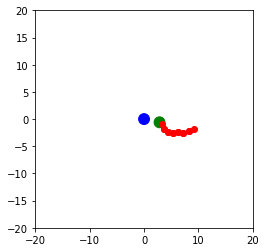

 31%|████████████▌                           | 6299/20000 [29:10<1:16:19,  2.99it/s]

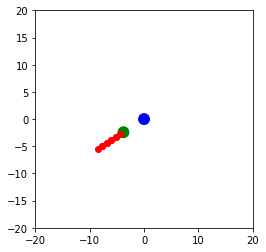

 32%|████████████▊                           | 6400/20000 [29:42<1:23:04,  2.73it/s]

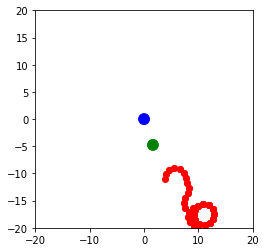

 32%|█████████████▋                            | 6500/20000 [30:06<57:18,  3.93it/s]

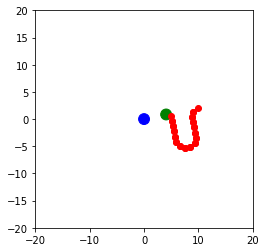

 33%|█████████████▊                            | 6600/20000 [30:34<46:15,  4.83it/s]

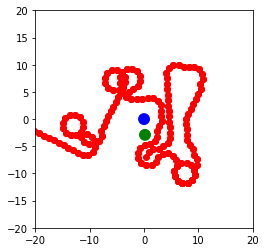

 34%|█████████████▍                          | 6700/20000 [31:01<1:15:17,  2.94it/s]

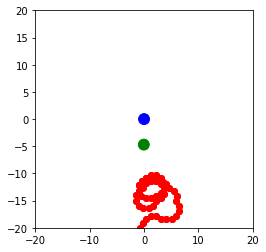

 34%|█████████████▌                          | 6799/20000 [31:34<1:30:23,  2.43it/s]

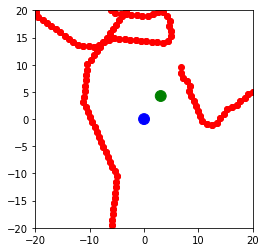

 34%|█████████████▋                          | 6839/20000 [31:48<1:26:28,  2.54it/s]

In [ ]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                # print("episode {}, the reward is {}".format(episode, round(reward, 3)))
                rewards.append(sum_rew)
                if episode % 100 == 0:
                    env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

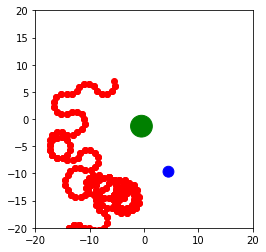

In [150]:
env.draw_map()

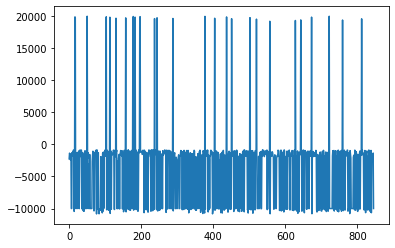

In [182]:
plt.plot(rewards)

In [183]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [184]:
m / (m + p)

0.9657210401891253

In [94]:
p

1860

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )